In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os

# Check if the file exists
file_path = '/content/drive/MyDrive/A_Z Handwritten Data.csv'
print("File exists:", os.path.isfile(file_path))

# List all files in the directory to check if it's there
for root, dirs, files in os.walk('/content/drive/MyDrive'):
    for file in files:
        print(os.path.join(root, file))



File exists: True
/content/drive/MyDrive/A_Z Handwritten Data.csv
/content/drive/MyDrive/Colab Notebooks/Untitled
/content/drive/MyDrive/Colab Notebooks/AI_proj_final5.ipynb


In [ ]:
# import pandas as pd
# df = pd.read_csv('/content/drive/My Drive/Handwritten.csv')
# df.head()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers import Nadam,Lamb
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
import tensorflow as tf
import os
import time
import math

In [4]:
from tensorflow.keras.optimizers import Lion  # Keras Optimizer for Lion
# from qhoptim.tf import QHAdamOptimizer

In [5]:
# print(tf.__version__)

In [6]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [7]:
# Check for GPU
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
optimizers = dir(tf.keras.optimizers)
print(optimizers)

['Adadelta', 'Adafactor', 'Adagrad', 'Adam', 'AdamW', 'Adamax', 'Ftrl', 'Lamb', 'Lion', 'LossScaleOptimizer', 'Nadam', 'Optimizer', 'RMSprop', 'SGD', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'deserialize', 'get', 'legacy', 'schedules', 'serialize']


In [9]:
# Function to visualize dataset samples
def visualize_samples(x, y, num_samples=20):
        plt.figure(figsize=(15, 4))
        for i in range(num_samples):
            plt.subplot(2, num_samples // 2, i + 1)
            plt.imshow(x[i].reshape(28, 28), cmap='gray')
            label_char = chr(y[i] + ord('A'))  # Map to character A-Z
            plt.title(label_char)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

def load_and_preprocess_data():
        az_file_path = '/content/drive/MyDrive/A_Z Handwritten Data.csv'

        try:
            print(f"Loading dataset from {az_file_path}...")
            az_data = pd.read_csv(az_file_path,on_bad_lines='skip')

            if az_data.isnull().values.any():
              print("Missing values found. Handling missing data...")
              az_data = az_data.dropna()

            print(f"Dataset shape: {az_data.shape}")
            label_col = az_data.columns[0]

            print(f"Using '{label_col}' as the label column")
            y_az = az_data[label_col].values.astype(int)
            x_az = az_data.drop(label_col, axis=1).values.astype(np.float32)

            label_counts = pd.Series(y_az).value_counts().sort_index()
            print("\nAdjusted Label Distribution:")
            for label, count in label_counts.items():
                label_char = chr(label + ord('A'))  # Mapping to characters A-Z
                print(f"  Label {label} ('{label_char}'): {count} samples ({count / len(y_az) * 100:.2f}%)")

            print(f"\nX data shape: {x_az.shape}, min: {np.min(x_az)}, max: {np.max(x_az)}")
            print(f"Y data shape: {y_az.shape}, unique labels: {np.unique(y_az)}")
            print("Successfully loaded A-Z dataset from file")

        except Exception as e:
            print(f"Error loading dataset: {e}")
            print("Creating a synthetic dataset for demonstration.")
            num_samples = 24000
            x_az = np.random.rand(num_samples, 28 * 28) * 255
            y_az = np.repeat(np.arange(26), 1000)  # 26 classes A-Z

        # Reshape and normalize
        x_az = np.nan_to_num(x_az)
        x_az = x_az.reshape(-1, 28, 28, 1).astype('float32') / 255.0

        # Train/test split
        x_train, x_test, y_train, y_test = train_test_split(
            x_az, y_az, test_size=0.2, random_state=42
        )

        # One-hot encoding (26 classes A–Z)
        y_train_cat = to_categorical(y_train, num_classes=26)
        y_test_cat = to_categorical(y_test, num_classes=26)

        # Visualize
        visualize_samples(x_train, y_train, 20)

        return x_train, y_train, y_train_cat, x_test, y_test, y_test_cat

In [13]:
# Function to visualize dataset samples
def visualize_samples(x, y, num_samples=20):
        plt.figure(figsize=(15, 4))
        for i in range(num_samples):
            plt.subplot(2, num_samples // 2, i + 1)
            plt.imshow(x[i].reshape(28, 28), cmap='gray')
            label_char = chr(y[i] + ord('A'))  # Map to character A-Z
            plt.title(label_char)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

def load_and_preprocess_data():
        az_file_path = '/content/drive/MyDrive/A_Z Handwritten Data.csv'

        try:
            print(f"Loading dataset from {az_file_path}...")
            az_data = pd.read_csv(az_file_path,on_bad_lines='skip')

            if az_data.isnull().values.any():
              print("Missing values found. Handling missing data...")
              az_data = az_data.dropna()

            print(f"Dataset shape: {az_data.shape}")
            label_col = az_data.columns[0]

            print(f"Using '{label_col}' as the label column")
            y_az = az_data[label_col].values.astype(int)
            x_az = az_data.drop(label_col, axis=1).values.astype(np.float32)

            label_counts = pd.Series(y_az).value_counts().sort_index()
            print("\nAdjusted Label Distribution:")
            for label, count in label_counts.items():
                label_char = chr(label + ord('A'))  # Mapping to characters A-Z
                print(f"  Label {label} ('{label_char}'): {count} samples ({count / len(y_az) * 100:.2f}%)")

            print(f"\nX data shape: {x_az.shape}, min: {np.min(x_az)}, max: {np.max(x_az)}")
            print(f"Y data shape: {y_az.shape}, unique labels: {np.unique(y_az)}")
            print("Successfully loaded A-Z dataset from file")

        except Exception as e:
            print(f"Error loading dataset: {e}")
            print("Creating a synthetic dataset for demonstration.")
            num_samples = 24000
            x_az = np.random.rand(num_samples, 28 * 28) * 255
            y_az = np.repeat(np.arange(26), 1000)  # 26 classes A-Z

        # Reshape and normalize
        x_az = np.nan_to_num(x_az)
        x_az = x_az.reshape(-1, 28, 28, 1).astype('float32') / 255.0

        # Train/test split
        x_train, x_test, y_train, y_test = train_test_split(
            x_az, y_az, test_size=0.2, random_state=42
        )

        # One-hot encoding (26 classes A–Z)
        y_train_cat = to_categorical(y_train, num_classes=26)
        y_test_cat = to_categorical(y_test, num_classes=26)

        # Visualize
        visualize_samples(x_train, y_train, 20)

        return x_train, y_train, y_train_cat, x_test, y_test, y_test_cat


def create_cnn_feature_extractor(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(0.01))(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(0.01))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(0.01))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    # Stop here - no final classification layers, just dense feature extraction
    outputs = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

def train_cnn_svm_model(x_train, y_train, y_train_cat, x_test, y_test, optimizer_name, learning_rate,
                         epochs=25, batch_size=128):
    # Create CNN feature extractor
    feature_extractor = create_cnn_feature_extractor(input_shape=(28, 28, 1))

    # Create a temporary classification layer just for training the CNN
    temp_model = Model(
        inputs=feature_extractor.input,
        outputs=Dense(26, activation='softmax')(feature_extractor.output)
    )

    # Print model summary
    temp_model.summary()

    print(f"Preparing optimizer '{optimizer_name}' with learning_rate={learning_rate}")

    # Create optimizer
    if optimizer_name == 'lion':
        optimizer = Lion(learning_rate=float(learning_rate))
    elif optimizer_name == 'adamw':
        optimizer = AdamW(learning_rate=float(learning_rate))
    elif optimizer_name == 'adam':
        optimizer = Adam(learning_rate=float(learning_rate))
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=float(learning_rate))
    elif optimizer_name == 'nadam':
        optimizer = Nadam(learning_rate=float(learning_rate))
    elif optimizer_name == 'lamb':
        optimizer = Lamb(learning_rate=float(learning_rate))
    else:
        raise ValueError(f"Unsupported optimizer name: {optimizer_name}")

    temp_model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    # Callbacks for better training
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]

    # Train CNN feature extractor
    print("Training CNN feature extractor...")
    start_time = time.time()
    history = temp_model.fit(
        x_train, y_train_cat,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, to_categorical(y_test, 26)),
        callbacks=callbacks,
        verbose=1
    )
    cnn_training_time = time.time() - start_time

    # Extract features for training data
    print("\nExtracting features from CNN for training set...")
    train_features = feature_extractor.predict(x_train, batch_size=batch_size)

    # Extract features for test data
    print("Extracting features from CNN for test set...")
    test_features = feature_extractor.predict(x_test, batch_size=batch_size)

    # Train SVM with default parameters
    print("\nTraining SVM with default parameters...")
    start_time = time.time()

    # Dimensionality reduction
    pca = PCA(n_components=100)
    train_features_pca = pca.fit_transform(train_features)
    test_features_pca = pca.transform(test_features)
    print(f"Reduced feature shape after PCA: {train_features_pca.shape}")

    # Use LinearSVC + Calibration for probabilities
    base_svm = LinearSVC(max_iter=5000)
    svm_classifier = CalibratedClassifierCV(base_svm, cv=3)  # enable probabilities
    svm_classifier.fit(train_features_pca, y_train)
    svm_training_time = time.time() - start_time

    # Get default parameters used
    svm_params = svm_classifier.get_params()

    # Final evaluation
    print("\nEvaluating CNN+SVM model on test data:")
    svm_predictions = svm_classifier.predict(test_features_pca)
    svm_accuracy = accuracy_score(y_test, svm_predictions)

    print(f"CNN+SVM Test accuracy: {svm_accuracy:.4f}")
    print(f"SVM parameters: {svm_params}")

    # Save the PCA object for later use
    import joblib
    joblib.dump(pca, f'pca_transformer_{optimizer_name}_{learning_rate}.joblib')

    return {
        'feature_extractor': feature_extractor,
        'svm_classifier': svm_classifier,
        'pca': pca,  # Include PCA in the result
        'svm_params': svm_params,
        'history': history,
        'test_accuracy': svm_accuracy,
        'cnn_training_time': cnn_training_time,
        'svm_training_time': svm_training_time,
        'total_training_time': cnn_training_time + svm_training_time,
        'optimizer': optimizer_name,
        'learning_rate': learning_rate
    }

def visualize_results(results):
    """
    Visualize the results of different CNN+SVM models with various optimizers and learning rates.

    Args:
        results: List of dictionaries containing the results of each model.
    """
    # Set up the figure for displaying results
    plt.figure(figsize=(15, 10))

    # Extract data for plotting
    optimizers = sorted(list(set([r['optimizer'] for r in results])))
    learning_rates = sorted(list(set([r['learning_rate'] for r in results])))

    # Create a colormap for different optimizers
    colors = plt.cm.tab10(np.linspace(0, 1, len(optimizers)))

    # Plot accuracy vs learning rate for each optimizer
    plt.subplot(2, 2, 1)
    for i, opt in enumerate(optimizers):
        opt_results = [r for r in results if r['optimizer'] == opt]
        if opt_results:
            lr_values = [r['learning_rate'] for r in opt_results]
            acc_values = [r['test_accuracy'] for r in opt_results]

            # Sort by learning rate for proper line plotting
            sorted_indices = np.argsort(lr_values)
            lr_values = [lr_values[j] for j in sorted_indices]
            acc_values = [acc_values[j] for j in sorted_indices]

            plt.plot(lr_values, acc_values, 'o-', color=colors[i], label=opt)

    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Test Accuracy')
    plt.title('Accuracy vs Learning Rate by Optimizer')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot training time vs optimizer
    plt.subplot(2, 2, 2)
    opt_times = {}
    for opt in optimizers:
        opt_results = [r for r in results if r['optimizer'] == opt]
        if opt_results:
            avg_time = np.mean([r['total_training_time'] for r in opt_results])
            opt_times[opt] = avg_time

    if opt_times:
        plt.bar(opt_times.keys(), opt_times.values(), color=colors[:len(opt_times)])
        plt.ylabel('Average Training Time (seconds)')
        plt.title('Training Time by Optimizer')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3, axis='y')

    # Plot best accuracy by optimizer
    plt.subplot(2, 2, 3)
    best_acc = {}
    for opt in optimizers:
        opt_results = [r for r in results if r['optimizer'] == opt]
        if opt_results:
            best_acc[opt] = max([r['test_accuracy'] for r in opt_results])

    if best_acc:
        plt.bar(best_acc.keys(), best_acc.values(), color=colors[:len(best_acc)])
        plt.ylabel('Best Test Accuracy')
        plt.title('Best Accuracy by Optimizer')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3, axis='y')

        # Add accuracy values on top of bars
        for opt, acc in best_acc.items():
            plt.text(opt, acc + 0.005, f'{acc:.4f}', ha='center')

    # Plot CNN vs SVM training time
    plt.subplot(2, 2, 4)
    cnn_times = [r['cnn_training_time'] for r in results]
    svm_times = [r['svm_training_time'] for r in results]

    if cnn_times and svm_times:
        labels = ['CNN Feature Extractor', 'SVM Classifier']
        times = [np.mean(cnn_times), np.mean(svm_times)]
        plt.bar(labels, times)
        plt.ylabel('Average Training Time (seconds)')
        plt.title('CNN vs SVM Training Time')
        plt.grid(True, alpha=0.3, axis='y')

        # Add time values on top of bars
        for i, t in enumerate(times):
            plt.text(i, t + 1, f'{t:.1f}s', ha='center')

    plt.tight_layout()
    plt.savefig('cnn_svm_results.png')
    plt.show()

    # Print best model details
    best_idx = np.argmax([r['test_accuracy'] for r in results])
    best_model = results[best_idx]
    print("\nBest Model:")
    print(f"Optimizer: {best_model['optimizer']}")
    print(f"Learning Rate: {best_model['learning_rate']}")
    print(f"Test Accuracy: {best_model['test_accuracy']:.4f}")
    print(f"Total Training Time: {best_model['total_training_time']:.2f} seconds")

def visualize_predictions(feature_extractor, svm_classifier, pca, x_test, y_test, num_samples=20):
    if np.min(y_test) == 1:
        print("Adjusting y_test labels to match 0-based indexing.")
        y_test = y_test - 1

    # Create a mapping from label to letter
    label_to_letter = {i: chr(65 + i) for i in range(26)}

    # Get CNN features
    test_features = feature_extractor.predict(x_test)

    # Apply PCA transformation using the provided PCA object
    test_features_pca = pca.transform(test_features)

    # Now predict with SVM using the transformed features
    svm_pred = svm_classifier.predict(test_features_pca)
    svm_pred_probs = svm_classifier.predict_proba(test_features_pca)

    # Calculate accuracy
    accuracy = np.mean(svm_pred == y_test)
    print(f"Overall accuracy: {accuracy:.4f}")

    # Find misclassified examples
    misclassified_indices = np.where(svm_pred != y_test)[0]
    print(f"Number of misclassified examples: {len(misclassified_indices)}")

    # Visualization of predictions
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    fig.suptitle('CNN+SVM Model Predictions', fontsize=16)

    # Show correct predictions
    correct_indices = np.where(svm_pred == y_test)[0]
    correct_sample_indices = np.random.choice(correct_indices, size=5, replace=False)

    for i, idx in enumerate(correct_sample_indices):
        ax = axes[0, i]
        ax.imshow(x_test[idx].reshape(28, 28), cmap='gray')
        confidence = svm_pred_probs[idx, svm_pred[idx]] * 100
        ax.set_title(f"True: {label_to_letter[y_test[idx]]}\n"
                     f"Pred: {label_to_letter[svm_pred[idx]]}\n"
                     f"Conf: {confidence:.1f}%",
                     color='green', fontsize=10)
        ax.axis('off')

    # Show incorrect predictions
    if len(misclassified_indices) > 0:
        incorrect_sample_indices = np.random.choice(
            misclassified_indices,
            size=min(5, len(misclassified_indices)),
            replace=False
        )
        for i, idx in enumerate(incorrect_sample_indices):
            ax = axes[1, i]
            ax.imshow(x_test[idx].reshape(28, 28), cmap='gray')
            confidence = svm_pred_probs[idx, svm_pred[idx]] * 100
            ax.set_title(f"True: {label_to_letter[y_test[idx]]}\n"
                         f"Pred: {label_to_letter[svm_pred[idx]]}\n"
                         f"Conf: {confidence:.1f}%",
                         color='red', fontsize=10)
            ax.axis('off')

    plt.tight_layout()
    plt.savefig('cnn_svm_predictions.png')
    plt.show()

    # Confusion matrix
    plt.figure(figsize=(15, 15))
    cm = confusion_matrix(y_test, svm_pred)
    labels = [chr(65 + i) for i in range(26)]

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('CNN+SVM Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.savefig('cnn_svm_confusion_matrix.png')
    plt.show()

def run_cnn_svm_experiments(x_train, y_train, y_train_cat, x_test, y_test, optimizers, learning_rates, epochs=25):
    results = []

    for optimizer_name in optimizers:
        for lr in learning_rates:
            print(f"\nTraining CNN+SVM with {optimizer_name} optimizer, learning rate: {lr}")
            try:
                result = train_cnn_svm_model(
                    x_train, y_train, y_train_cat, x_test, y_test,
                    optimizer_name=optimizer_name,
                    learning_rate=float(lr),
                    epochs=epochs
                )
                results.append(result)
                print(f"CNN+SVM Accuracy: {result['test_accuracy']:.4f}")
                print(f"Total Training Time: {result['total_training_time']:.2f} seconds")
                print(f"Best SVM Parameters: {result['svm_params']}")
            except Exception as e:
                print(f"Error training with {optimizer_name}, lr={lr}: {e}")

    return results


# Also add a function to load and use the saved model for prediction
# def load_and_predict(image_data):
#     """
#     Load the trained model and make predictions on new data

#     Args:
#         image_data: Preprocessed image data with shape (n, 28, 28, 1)
#                    Should be normalized to [0,1]

#     Returns:
#         predictions: Class predictions (0-25 for A-Z)
#         confidence: Probability for each prediction
#     """
#     # Load the feature extractor
#     feature_extractor = tf.keras.models.load_model('best_az_feature_extractor.h5')

#     # Load the SVM classifier
#     import joblib
#     svm_classifier = joblib.load('best_az_svm_classifier.joblib')

#     # Load the PCA transformer
#     pca = joblib.load('best_az_pca_transformer.joblib')

#     # Extract features
#     features = feature_extractor.predict(image_data)

#     # Apply PCA transformation
#     features_pca = pca.transform(features)

#     # Predict with SVM
#     predictions = svm_classifier.predict(features_pca)
#     probabilities = svm_classifier.predict_proba(features_pca)

#     # Get confidence for each prediction
#     confidence = np.max(probabilities, axis=1)

#     # Convert numeric predictions to letters
#     letter_predictions = [chr(65 + p) for p in predictions]

#     return predictions, letter_predictions, confidence

Loading and preprocessing data...
Loading dataset from /content/drive/MyDrive/A_Z Handwritten Data.csv...
Dataset shape: (372450, 785)
Using '0' as the label column

Adjusted Label Distribution:
  Label 0 ('A'): 13869 samples (3.72%)
  Label 1 ('B'): 8668 samples (2.33%)
  Label 2 ('C'): 23409 samples (6.29%)
  Label 3 ('D'): 10134 samples (2.72%)
  Label 4 ('E'): 11440 samples (3.07%)
  Label 5 ('F'): 1163 samples (0.31%)
  Label 6 ('G'): 5762 samples (1.55%)
  Label 7 ('H'): 7218 samples (1.94%)
  Label 8 ('I'): 1120 samples (0.30%)
  Label 9 ('J'): 8493 samples (2.28%)
  Label 10 ('K'): 5603 samples (1.50%)
  Label 11 ('L'): 11586 samples (3.11%)
  Label 12 ('M'): 12336 samples (3.31%)
  Label 13 ('N'): 19010 samples (5.10%)
  Label 14 ('O'): 57825 samples (15.53%)
  Label 15 ('P'): 19341 samples (5.19%)
  Label 16 ('Q'): 5812 samples (1.56%)
  Label 17 ('R'): 11566 samples (3.11%)
  Label 18 ('S'): 48419 samples (13.00%)
  Label 19 ('T'): 22495 samples (6.04%)
  Label 20 ('U'): 290

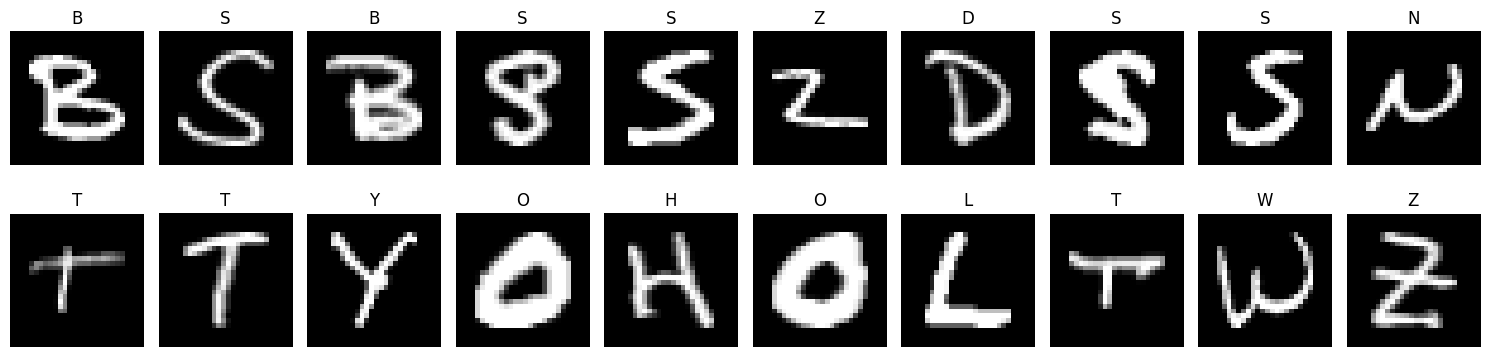


Running CNN+SVM experiments with default SVM parameters...

Training CNN+SVM with lamb optimizer, learning rate: 0.01


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 696,346 (2.66 MB)

 Trainable params: 696,346 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

Preparing optimizer 'lamb' with learning_rate=0.01
Training CNN feature extractor...
Epoch 1/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.8515 - loss: 1.8094 - val_accuracy: 0.9559 - val_loss: 0.2631 - learning_rate: 0.0100
Epoch 2/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - accuracy: 0.9614 - loss: 0.2411 - val_accuracy: 0.9560 - val_loss: 0.2627 - learning_rate: 0.0100
Epoch 3/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9503 - loss: 0.2964 - val_accuracy: 0.9467 - val_loss: 0.3344 - learning_rate: 0.0100
Epoch 4/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9445 - loss: 0.3552 - val_accuracy: 0.9257 - val_loss: 0.4522 - learning_rate: 0.0100
Epoch 5/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9453 - loss: 0.3776 - val_accuracy: 0.9544 - val_loss: 0.3537 - learning_rate: 0.0100
Epoch 6/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9658 - loss: 0.2560 - val_accuracy: 0.9721 - val_loss: 0.1871 - learnin

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 696,346 (2.66 MB)

 Trainable params: 696,346 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

Preparing optimizer 'lamb' with learning_rate=0.001
Training CNN feature extractor...
Epoch 1/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.6393 - loss: 6.1024 - val_accuracy: 0.9509 - val_loss: 1.4063 - learning_rate: 0.0010
Epoch 2/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9527 - loss: 1.1487 - val_accuracy: 0.9649 - val_loss: 0.6835 - learning_rate: 0.0010
Epoch 3/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9619 - loss: 0.6233 - val_accuracy: 0.9689 - val_loss: 0.4739 - learning_rate: 0.0010
Epoch 4/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9663 - loss: 0.4507 - val_accuracy: 0.9710 - val_loss: 0.3790 - learning_rate: 0.0010
Epoch 5/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9689 - loss: 0.3665 - val_accuracy: 0.9724 - val_loss: 0.3252 - learning_rate: 0.0010
Epoch 6/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9711 - loss: 0.3153 - val_accuracy: 0.9739 - val_loss: 0.2887 - learni

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 696,346 (2.66 MB)

 Trainable params: 696,346 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

Preparing optimizer 'lamb' with learning_rate=0.0001
Training CNN feature extractor...
Epoch 1/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.1802 - loss: 10.6241 - val_accuracy: 0.5421 - val_loss: 7.6921 - learning_rate: 1.0000e-04
Epoch 2/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.6188 - loss: 6.9181 - val_accuracy: 0.8063 - val_loss: 5.2155 - learning_rate: 1.0000e-04
Epoch 3/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.8283 - loss: 4.8708 - val_accuracy: 0.8827 - val_loss: 4.0361 - learning_rate: 1.0000e-04
Epoch 4/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.8907 - loss: 3.8428 - val_accuracy: 0.9153 - val_loss: 3.3488 - learning_rate: 1.0000e-04
Epoch 5/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9178 - loss: 3.2290 - val_accuracy: 0.9320 - val_loss: 2.9013 - learning_rate: 1.0000e-04
Epoch 6/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9329 - loss: 2.8148 - val_accuracy: 0.9424 - val

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 696,346 (2.66 MB)

 Trainable params: 696,346 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

Preparing optimizer 'adamw' with learning_rate=0.01
Training CNN feature extractor...
Epoch 1/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.7675 - loss: 1.2374 - val_accuracy: 0.8986 - val_loss: 0.5737 - learning_rate: 0.0100
Epoch 2/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9161 - loss: 0.5111 - val_accuracy: 0.9284 - val_loss: 0.4929 - learning_rate: 0.0100
Epoch 3/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9207 - loss: 0.4881 - val_accuracy: 0.9304 - val_loss: 0.4478 - learning_rate: 0.0100
Epoch 4/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9227 - loss: 0.4601 - val_accuracy: 0.9363 - val_loss: 0.4166 - learning_rate: 0.0100
Epoch 5/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9269 - loss: 0.4432 - val_accuracy: 0.9379 - val_loss: 0.4093 - learning_rate: 0.0100
Epoch 6/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9307 - loss: 0.4270 - val_accuracy: 0.9285 - val_loss: 0.4424 - learni

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 696,346 (2.66 MB)

 Trainable params: 696,346 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

Preparing optimizer 'adamw' with learning_rate=0.001
Training CNN feature extractor...
Epoch 1/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.8613 - loss: 1.2978 - val_accuracy: 0.9478 - val_loss: 0.4547 - learning_rate: 0.0010
Epoch 2/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9477 - loss: 0.4272 - val_accuracy: 0.9503 - val_loss: 0.4037 - learning_rate: 0.0010
Epoch 3/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9516 - loss: 0.3839 - val_accuracy: 0.9543 - val_loss: 0.3712 - learning_rate: 0.0010
Epoch 4/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9544 - loss: 0.3579 - val_accuracy: 0.9524 - val_loss: 0.3649 - learning_rate: 0.0010
Epoch 5/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9567 - loss: 0.3401 - val_accuracy: 0.9536 - val_loss: 0.3514 - learning_rate: 0.0010
Epoch 6/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9586 - loss: 0.3260 - val_accuracy: 0.9548 - val_loss: 0.3414 - learn

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 696,346 (2.66 MB)

 Trainable params: 696,346 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

Preparing optimizer 'adamw' with learning_rate=0.0001
Training CNN feature extractor...
Epoch 1/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.7185 - loss: 4.3533 - val_accuracy: 0.9415 - val_loss: 0.9781 - learning_rate: 1.0000e-04
Epoch 2/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9465 - loss: 0.8050 - val_accuracy: 0.9514 - val_loss: 0.5405 - learning_rate: 1.0000e-04
Epoch 3/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9547 - loss: 0.4910 - val_accuracy: 0.9552 - val_loss: 0.4427 - learning_rate: 1.0000e-04
Epoch 4/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9579 - loss: 0.4168 - val_accuracy: 0.9577 - val_loss: 0.4081 - learning_rate: 1.0000e-04
Epoch 5/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9600 - loss: 0.3899 - val_accuracy: 0.9598 - val_loss: 0.3873 - learning_rate: 1.0000e-04
Epoch 6/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9615 - loss: 0.3740 - val_accuracy: 0.9620 - val

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 696,346 (2.66 MB)

 Trainable params: 696,346 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

Preparing optimizer 'adam' with learning_rate=0.01
Training CNN feature extractor...
Epoch 1/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.8066 - loss: 1.0663 - val_accuracy: 0.9225 - val_loss: 0.5149 - learning_rate: 0.0100
Epoch 2/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9191 - loss: 0.5212 - val_accuracy: 0.9358 - val_loss: 0.4482 - learning_rate: 0.0100
Epoch 3/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9237 - loss: 0.5014 - val_accuracy: 0.9313 - val_loss: 0.4521 - learning_rate: 0.0100
Epoch 4/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9286 - loss: 0.4476 - val_accuracy: 0.9435 - val_loss: 0.4007 - learning_rate: 0.0100
Epoch 5/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9295 - loss: 0.4347 - val_accuracy: 0.9389 - val_loss: 0.4106 - learning_rate: 0.0100
Epoch 6/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9304 - loss: 0.4295 - val_accuracy: 0.9442 - val_loss: 0.3890 - learnin

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 696,346 (2.66 MB)

 Trainable params: 696,346 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

Preparing optimizer 'adam' with learning_rate=0.001
Training CNN feature extractor...
Epoch 1/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.8598 - loss: 1.3052 - val_accuracy: 0.9502 - val_loss: 0.4415 - learning_rate: 0.0010
Epoch 2/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9467 - loss: 0.4276 - val_accuracy: 0.9522 - val_loss: 0.3988 - learning_rate: 0.0010
Epoch 3/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9513 - loss: 0.3822 - val_accuracy: 0.9532 - val_loss: 0.3743 - learning_rate: 0.0010
Epoch 4/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9542 - loss: 0.3550 - val_accuracy: 0.9542 - val_loss: 0.3533 - learning_rate: 0.0010
Epoch 5/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9565 - loss: 0.3363 - val_accuracy: 0.9547 - val_loss: 0.3404 - learning_rate: 0.0010
Epoch 6/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9579 - loss: 0.3232 - val_accuracy: 0.9557 - val_loss: 0.3306 - learni

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 696,346 (2.66 MB)

 Trainable params: 696,346 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

Preparing optimizer 'adam' with learning_rate=0.0001
Training CNN feature extractor...
Epoch 1/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.7160 - loss: 4.3688 - val_accuracy: 0.9445 - val_loss: 0.9298 - learning_rate: 1.0000e-04
Epoch 2/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9476 - loss: 0.7606 - val_accuracy: 0.9522 - val_loss: 0.5151 - learning_rate: 1.0000e-04
Epoch 3/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9552 - loss: 0.4706 - val_accuracy: 0.9556 - val_loss: 0.4317 - learning_rate: 1.0000e-04
Epoch 4/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9582 - loss: 0.4086 - val_accuracy: 0.9595 - val_loss: 0.3985 - learning_rate: 1.0000e-04
Epoch 5/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9602 - loss: 0.3850 - val_accuracy: 0.9619 - val_loss: 0.3791 - learning_rate: 1.0000e-04
Epoch 6/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9616 - loss: 0.3700 - val_accuracy: 0.9635 - val_

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 696,346 (2.66 MB)

 Trainable params: 696,346 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

Preparing optimizer 'rmsprop' with learning_rate=0.01
Training CNN feature extractor...
Epoch 1/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.1517 - loss: 3.0707 - val_accuracy: 0.1561 - val_loss: 2.9302 - learning_rate: 0.0100
Epoch 2/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.1553 - loss: 2.9290 - val_accuracy: 0.1561 - val_loss: 2.9301 - learning_rate: 0.0100
Epoch 3/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.1553 - loss: 2.9284 - val_accuracy: 0.1561 - val_loss: 2.9301 - learning_rate: 0.0100
Epoch 4/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.1553 - loss: 2.9284 - val_accuracy: 0.1561 - val_loss: 2.9301 - learning_rate: 0.0100
Epoch 5/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.1553 - loss: 2.9284 - val_accuracy: 0.1561 - val_loss: 2.9301 - learning_rate: 0.0100
Epoch 6/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.1553 - loss: 2.9279 - val_accuracy: 0.1561 - val_loss: 2.9300 - lear

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


Reduced feature shape after PCA: (297960, 100)

Evaluating CNN+SVM model on test data:
CNN+SVM Test accuracy: 0.1561
SVM parameters: {'cv': 3, 'ensemble': 'auto', 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': 'auto', 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__loss': 'squared_hinge', 'estimator__max_iter': 5000, 'estimator__multi_class': 'ovr', 'estimator__penalty': 'l2', 'estimator__random_state': None, 'estimator__tol': 0.0001, 'estimator__verbose': 0, 'estimator': LinearSVC(max_iter=5000), 'method': 'sigmoid', 'n_jobs': None}
CNN+SVM Accuracy: 0.1561
Total Training Time: 417.15 seconds
SVM Parameters: {'cv': 3, 'ensemble': 'auto', 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': 'auto', 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__loss': 'squared_hinge', 'estimator__max_iter': 5000, 'estimator__multi_class': 'ovr', 'estimator__penalty': 'l2', 'estimator__random

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 696,346 (2.66 MB)

 Trainable params: 696,346 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

Preparing optimizer 'rmsprop' with learning_rate=0.001
Training CNN feature extractor...
Epoch 1/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.8351 - loss: 1.3751 - val_accuracy: 0.9290 - val_loss: 0.4689 - learning_rate: 0.0010
Epoch 2/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9407 - loss: 0.4298 - val_accuracy: 0.9344 - val_loss: 0.4174 - learning_rate: 0.0010
Epoch 3/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9462 - loss: 0.3856 - val_accuracy: 0.9410 - val_loss: 0.3840 - learning_rate: 0.0010
Epoch 4/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9493 - loss: 0.3608 - val_accuracy: 0.9488 - val_loss: 0.3558 - learning_rate: 0.0010
Epoch 5/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9519 - loss: 0.3442 - val_accuracy: 0.9519 - val_loss: 0.3412 - learning_rate: 0.0010
Epoch 6/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9537 - loss: 0.3322 - val_accuracy: 0.9564 - val_loss: 0.3237 - lea

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 696,346 (2.66 MB)

 Trainable params: 696,346 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

Preparing optimizer 'rmsprop' with learning_rate=0.0001
Training CNN feature extractor...
Epoch 1/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.6944 - loss: 4.6965 - val_accuracy: 0.9267 - val_loss: 1.1159 - learning_rate: 1.0000e-04
Epoch 2/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9449 - loss: 0.8470 - val_accuracy: 0.9460 - val_loss: 0.5430 - learning_rate: 1.0000e-04
Epoch 3/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9546 - loss: 0.4803 - val_accuracy: 0.9509 - val_loss: 0.4459 - learning_rate: 1.0000e-04
Epoch 4/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9578 - loss: 0.4096 - val_accuracy: 0.9521 - val_loss: 0.4174 - learning_rate: 1.0000e-04
Epoch 5/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9597 - loss: 0.3823 - val_accuracy: 0.9530 - val_loss: 0.4014 - learning_rate: 1.0000e-04
Epoch 6/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9609 - loss: 0.3655 - val_accuracy: 0.9545 - v

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 696,346 (2.66 MB)

 Trainable params: 696,346 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

Preparing optimizer 'lion' with learning_rate=0.01
Training CNN feature extractor...
Epoch 1/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.7278 - loss: 1.7321 - val_accuracy: 0.7616 - val_loss: 1.2682 - learning_rate: 0.0100
Epoch 2/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8536 - loss: 0.9857 - val_accuracy: 0.8450 - val_loss: 0.9955 - learning_rate: 0.0100
Epoch 3/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8533 - loss: 0.9763 - val_accuracy: 0.8545 - val_loss: 0.9585 - learning_rate: 0.0100
Epoch 4/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8530 - loss: 0.9723 - val_accuracy: 0.8434 - val_loss: 1.0019 - learning_rate: 0.0100
Epoch 5/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8541 - loss: 0.9687 - val_accuracy: 0.8634 - val_loss: 0.9376 - learning_rate: 0.0100
Epoch 6/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.8531 - loss: 0.9754 - val_accuracy: 0.8590 - val_loss: 0.9736 - learnin

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 696,346 (2.66 MB)

 Trainable params: 696,346 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

Preparing optimizer 'lion' with learning_rate=0.001
Training CNN feature extractor...
Epoch 1/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8758 - loss: 1.2563 - val_accuracy: 0.9495 - val_loss: 0.3865 - learning_rate: 0.0010
Epoch 2/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9532 - loss: 0.3614 - val_accuracy: 0.9617 - val_loss: 0.3262 - learning_rate: 0.0010
Epoch 3/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9567 - loss: 0.3316 - val_accuracy: 0.9628 - val_loss: 0.3078 - learning_rate: 0.0010
Epoch 4/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9579 - loss: 0.3178 - val_accuracy: 0.9549 - val_loss: 0.3252 - learning_rate: 0.0010
Epoch 5/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9585 - loss: 0.3072 - val_accuracy: 0.9582 - val_loss: 0.3084 - learning_rate: 0.0010
Epoch 6/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9593 - loss: 0.2979 - val_accuracy: 0.9591 - val_loss: 0.2971 - learni

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 696,346 (2.66 MB)

 Trainable params: 696,346 (2.66 MB)

 Non-trainable params: 0 (0.00 B)

Preparing optimizer 'lion' with learning_rate=0.0001
Training CNN feature extractor...
Epoch 1/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.7097 - loss: 3.3481 - val_accuracy: 0.9591 - val_loss: 0.3778 - learning_rate: 1.0000e-04
Epoch 2/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9575 - loss: 0.3669 - val_accuracy: 0.9643 - val_loss: 0.3276 - learning_rate: 1.0000e-04
Epoch 3/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9615 - loss: 0.3222 - val_accuracy: 0.9661 - val_loss: 0.3004 - learning_rate: 1.0000e-04
Epoch 4/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9635 - loss: 0.2988 - val_accuracy: 0.9677 - val_loss: 0.2830 - learning_rate: 1.0000e-04
Epoch 5/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9651 - loss: 0.2839 - val_accuracy: 0.9681 - val_loss: 0.2746 - learning_rate: 1.0000e-04
Epoch 6/25
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9666 - loss: 0.2727 - val_accuracy: 0.9691 - val_

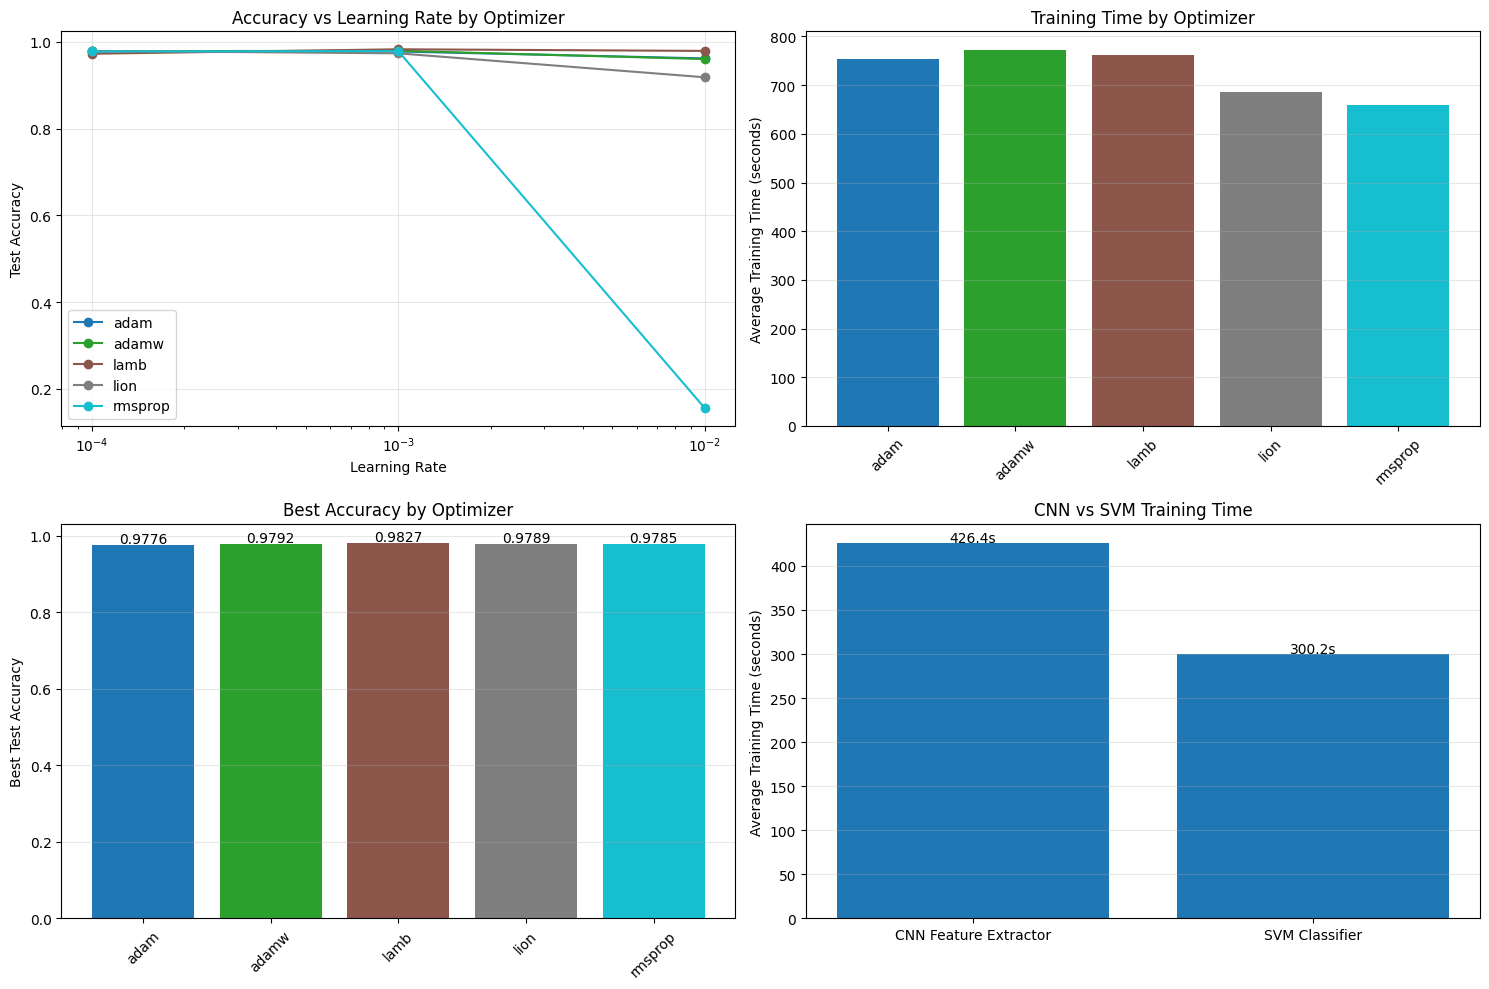


Best Model:
Optimizer: lamb
Learning Rate: 0.001
Test Accuracy: 0.9827
Total Training Time: 677.11 seconds

Model Rankings:
 Rank Optimizer  Learning Rate  Accuracy  Training Time
    1      lamb         0.0010  0.982669     677.114067
    2     adamw         0.0010  0.979205     768.651284
    3      lion         0.0001  0.978910     752.322752
    4      lamb         0.0100  0.978896     661.324091
    5   rmsprop         0.0010  0.978494     719.383255
    6     adamw         0.0001  0.978225     869.519722
    7      adam         0.0001  0.977621     859.570676
    8      adam         0.0010  0.977567     760.487900
    9   rmsprop         0.0001  0.977567     843.257676
   10      lion         0.0010  0.973339     701.517227
   11      lamb         0.0001  0.972372     948.239611
   12      adam         0.0100  0.961646     641.429055
   13     adamw         0.0100  0.960129     677.661310
   14      lion         0.0100  0.918164     601.795418
   15   rmsprop         0.0100  0.1

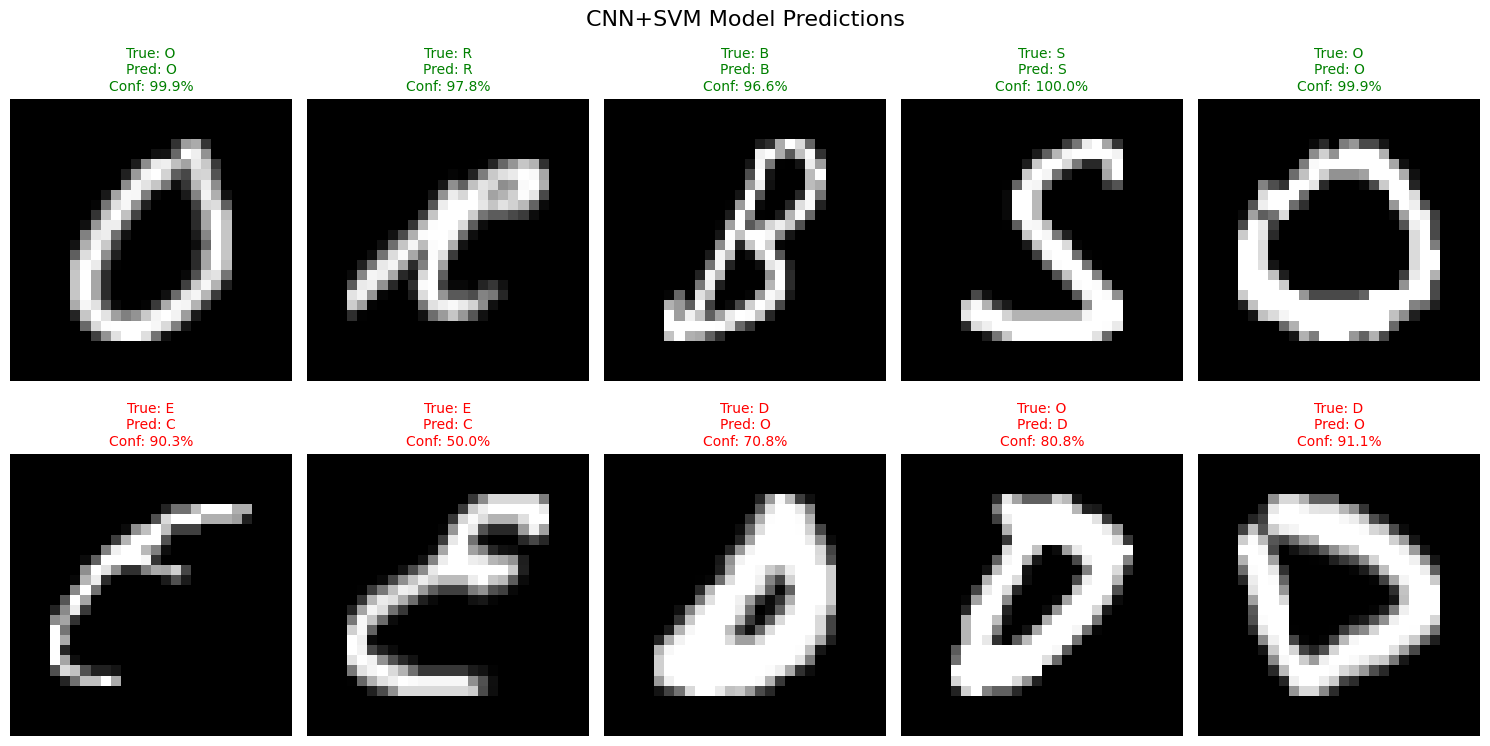

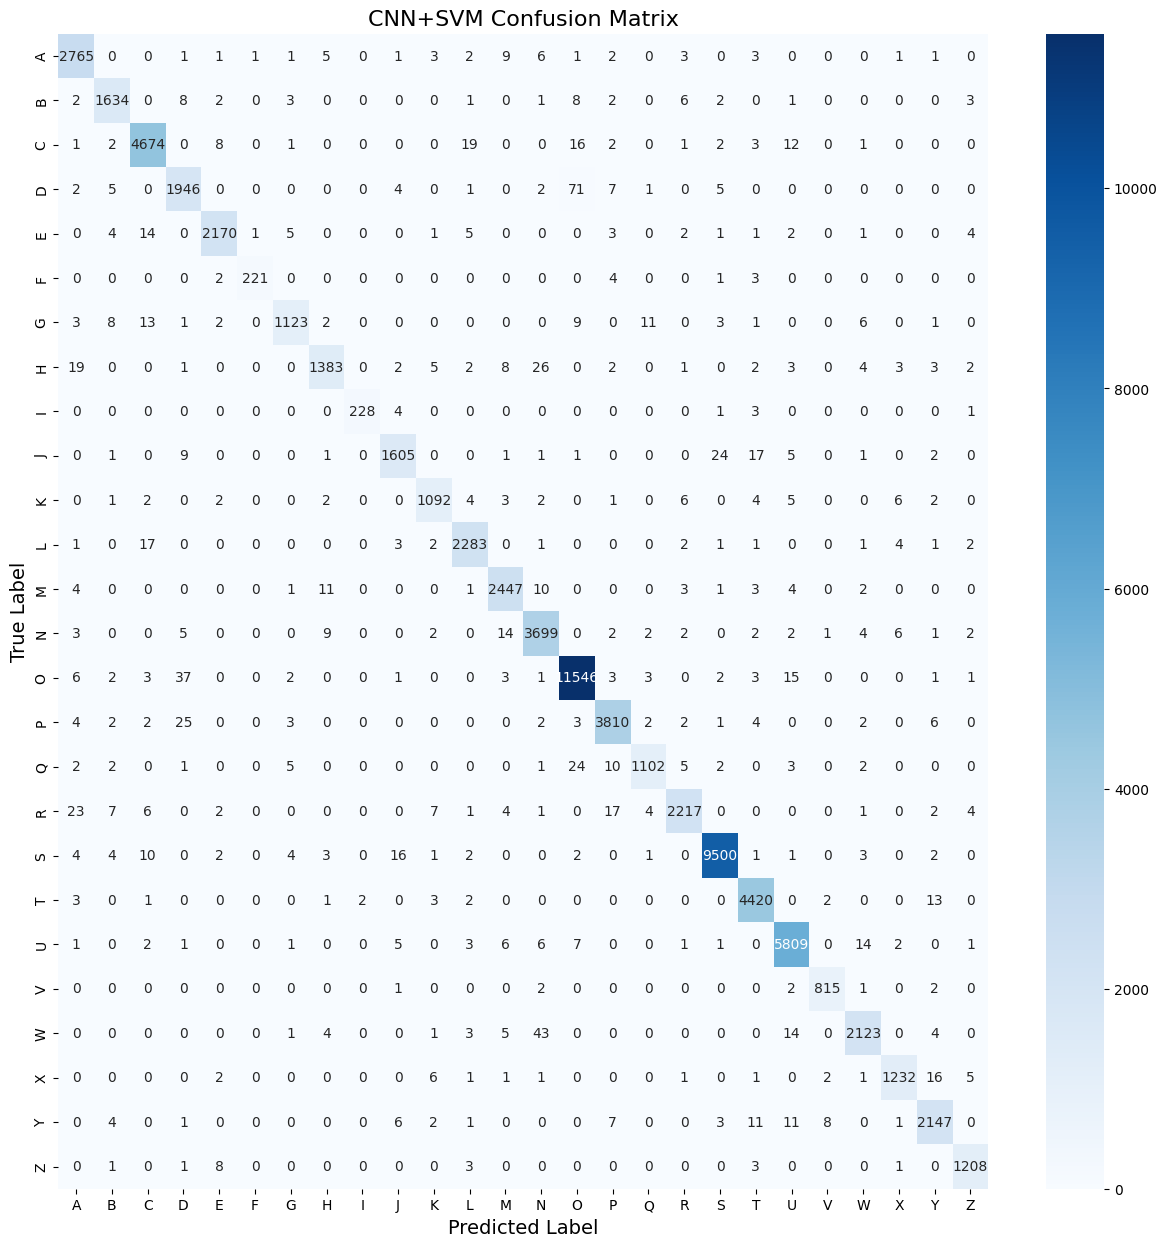

TypeError: Object of type LinearSVC is not JSON serializable

In [15]:
def main():
    # Parameters
    optimizers = ['lamb', 'adamw', 'adam', 'rmsprop', 'lion']
    learning_rates = [0.01, 0.001, 0.0001]
    epochs = 25
    batch_size = 128

    # Load and preprocess data
    print("Loading and preprocessing data...")
    x_train, y_train, y_train_cat, x_test, y_test, y_test_cat = load_and_preprocess_data()

    # Run CNN+SVM experiments with default SVM parameters
    print("\nRunning CNN+SVM experiments with default SVM parameters...")
    results = []

    for optimizer_name in optimizers:
        for lr in learning_rates:
            print(f"\nTraining CNN+SVM with {optimizer_name} optimizer, learning rate: {lr}")
            try:
                result = train_cnn_svm_model(
                    x_train, y_train, y_train_cat, x_test, y_test,
                    optimizer_name=optimizer_name,
                    learning_rate=float(lr),
                    epochs=epochs,
                    batch_size=batch_size
                )
                results.append(result)
                print(f"CNN+SVM Accuracy: {result['test_accuracy']:.4f}")
                print(f"Total Training Time: {result['total_training_time']:.2f} seconds")
                print(f"SVM Parameters: {result['svm_params']}")
            except Exception as e:
                print(f"Error training with {optimizer_name}, lr={lr}: {e}")

    # Visualize all results
    print("\nVisualizing results...")
    visualize_results(results)

    # Find best model
    best_model_idx = np.argmax([r['test_accuracy'] for r in results])
    best_model = results[best_model_idx]

    # Create a ranking of all models
    print("\nModel Rankings:")
    ranking_df = pd.DataFrame([
        {
            'Rank': i+1,
            'Optimizer': r['optimizer'],
            'Learning Rate': r['learning_rate'],
            'Accuracy': r['test_accuracy'],
            'Training Time': r['total_training_time']
        }
        for i, r in enumerate(sorted(results, key=lambda x: x['test_accuracy'], reverse=True))
    ])
    print(ranking_df.to_string(index=False))

    # Visualize predictions for best model
    print("\nVisualizing sample predictions...")
    visualize_predictions(
        best_model['feature_extractor'],
        best_model['svm_classifier'],
        best_model['pca'],  # Pass the PCA object
        x_test, y_test, 20
    )

    # Save best model components and parameters
    best_model['feature_extractor'].save('best_az_feature_extractor.h5')

    # Import joblib for saving the SVM model and PCA
    import joblib
    joblib.dump(best_model['svm_classifier'], 'best_az_svm_classifier.joblib')
    joblib.dump(best_model['pca'], 'best_az_pca_transformer.joblib')

    # Save best parameters
    with open('best_svm_parameters.json', 'w') as f:
        import json
        # Convert numpy types to native Python types for JSON serialization
        params_to_save = {}
        for key, value in best_model['svm_params'].items():
            if isinstance(value, np.integer):
                params_to_save[key] = int(value)
            elif isinstance(value, np.floating):
                params_to_save[key] = float(value)
            else:
                params_to_save[key] = value
        json.dump(params_to_save, f, indent=4)

    print("\nBest model components saved:")
    print("- Feature extractor: 'best_az_feature_extractor.h5'")
    print("- SVM classifier: 'best_az_svm_classifier.joblib'")
    print("- PCA transformer: 'best_az_pca_transformer.joblib'")
    print("- SVM parameters: 'best_svm_parameters.json'")

    return results

if __name__ == "__main__":
    main()